# Exploratory Data Analysis for r/AmItheAsshole (r/AITA)

This notebook covers the initial data exploration relating solely to r/AmItheAsshole in relation to our business goal of analyzing and predicting flair occurrences based on posts' text content.

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.2.0

# Install squarify for plotting
!pip install squarify

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.7.22          |  py310h06a4308_0         153 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/

In [ ]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import os
import json
import pyspark.sql.functions as F
import squarify
from pyspark import SparkConf

Below we read in all of the submissions and comments for our subreddits of interest for the year of 2022

In [13]:
%%time
# Read in data from project bucket
bucket = "project17-bucket-alex"
#output_prefix_data = "project_2022"

# List of 12 directories each containing 1 month of data
directories = ["project_2022_"+str(i)+"/submissions" for i in range(1,13)]

# Iterate through 12 directories and merge each monthly data set to create one big data set
df = None
for directory in directories:
    s3_path = f"s3a://{bucket}/{directory}"
    month_df = spark.read.parquet(s3_path, header = True)
    
    if df is None:
        df = month_df
    else:
        df = df.union(month_df)

submissions = df
print(f"reading submissions from {s3_path}")
#submissions = spark.read.parquet(s3_path, header=True)
print(f"shape of the submissions dataframe is {submissions.count():,}x{len(submissions.columns)}")

KeyError: 'c'

In [18]:
# display a subset of columns
submissions.select("subreddit", "author", "title", "selftext", "created_utc", "num_comments", "link_flair_text").show()

+-------------------+-------------------+--------------------+--------------------+-------------------+------------+----------------+
|          subreddit|             author|               title|            selftext|        created_utc|num_comments| link_flair_text|
+-------------------+-------------------+--------------------+--------------------+-------------------+------------+----------------+
|  NoStupidQuestions|          [deleted]|Who do you call w...|           [deleted]|2022-01-22 18:14:03|           4|            null|
|      AmItheAsshole|          [deleted]|AITA for blowing ...|           [removed]|2022-01-22 18:14:04|           7|            null|
|      AmItheAsshole|       go_awaythrow|AITA if I cut my ...|           [removed]|2022-01-22 18:14:12|           1|            null|
|  NoStupidQuestions|          [deleted]|   [deleted by user]|           [removed]|2022-01-22 18:14:16|           1|            null|
|             AskMen|          [deleted]|Do men actually l...|

Now that the r/AITA data has been read in, we must subset to remove the posts where the text is removed or there is no text at all. These represent posts deleted by the user (when these data were scraped from Reddit) or posts that were removed by moderators (i.e., for rule violations).

In [24]:
%%time

submissions.select("subreddit", "author", "title", "selftext", "created_utc", "num_comments", "link_flair_text").orderBy(F.col("created_utc"), ascending=True).show()

+-------------------+--------------------+--------------------+--------------------+-------------------+------------+--------------------+
|          subreddit|              author|               title|            selftext|        created_utc|num_comments|     link_flair_text|
+-------------------+--------------------+--------------------+--------------------+-------------------+------------+--------------------+
|   unpopularopinion|          narj_eagle|I enjoy small tal...|           [removed]|2022-01-01 00:00:13|           1|                null|
|   unpopularopinion|           [deleted]|The Subway menu i...|           [removed]|2022-01-01 00:00:14|          46|R2 - No troll/sat...|
|   unpopularopinion|           [deleted]|   [deleted by user]|           [removed]|2022-01-01 00:00:17|           1|                null|
|             AskMen|           [deleted]|   [deleted by user]|           [removed]|2022-01-01 00:00:21|           1|                null|
|  explainlikeimfive|      

In [27]:
%% time
# Here we subset the submissions to only include posts from r/AmItheAsshole for the subsequent analysis
raw_aita = submissions.filter(F.col('subreddit') == "AmItheAsshole")

# filter submissions to remove deleted/removed posts
aita = raw_aita.filter((F.col('selftext') != '[removed]') & (F.col('selftext') != '[deleted]' ))
aita.select("subreddit", "author", "title", "selftext", "created_utc", "num_comments", "link_flair_text").show()

print(f"shape of the subsetted submissions dataframe is {aita.count():,}x{len(aita.columns)}")

+-------------+--------------------+--------------------+--------------------+-------------------+------------+---------------+
|    subreddit|              author|               title|            selftext|        created_utc|num_comments|link_flair_text|
+-------------+--------------------+--------------------+--------------------+-------------------+------------+---------------+
|AmItheAsshole|       geosunsetmoth|AITA for refusing...|I (NB 19) am auti...|2022-01-22 18:15:30|         425| Not the A-hole|
|AmItheAsshole|           pezewuziz|AITA for charging...|So for a bit of b...|2022-01-22 18:28:39|          56| Everyone Sucks|
|AmItheAsshole|            twilipig|AITA for refusing...|Just a bit of bac...|2022-01-22 18:52:52|          52| Not the A-hole|
|AmItheAsshole|              joreia|AITA for not want...|So I’m (32F) a mo...|2022-01-13 02:17:23|          29| Not the A-hole|
|AmItheAsshole|       BazilbeeChuck|AITA for offering...|\nI (29M) have a ...|2022-01-13 02:32:24|      

shape of the subsetted submissions dataframe is 115,665x68


With the unusable posts removed, we can now analyze the flair counts to get an idea of how Redditors assess r/AITA posts on average.

In [28]:
%%time
aita.groupby('link_flair_text').count().show()

+---------------+-----+
|link_flair_text|count|
+---------------+-----+
|           META|    9|
| Everyone Sucks| 4237|
|   Best of 2021|    3|
|Not enough info| 2290|
| Not the A-hole|85494|
|         UPDATE|  302|
|          TL;DR| 1522|
|No A-holes here| 5191|
|               |  170|
|        Asshole|15465|
|     Talk ENDED|    5|
|     Open Forum|   11|
|      Talk LIVE|    1|
|    META: Help!|    1|
| Upcoming Talk!|    1|
|           null|  963|
+---------------+-----+

CPU times: user 133 ms, sys: 15.6 ms, total: 149 ms
Wall time: 6min 21s


As we can see from the value counts above, Redditors (at least for the time frame in question) most commonly rate posts as Not the A-hole. We only are concerned with posts that are either: Not the A-hole, Asshole, Everyone Sucks, or No A-holes here, which are the 4 usual "judgments" that are imbued upon each post, so these data are subsetted further below.

In [29]:
%%time
acceptable_flairs = ['Everyone Sucks', 'Not the A-hole', 'No A-holes here', 'Asshole']
df_flairs = aita.where(F.col('link_flair_text').isin(acceptable_flairs))
df_flairs.select("subreddit", "author", "title", "selftext", "created_utc", "num_comments", "link_flair_text").show()
df_flairs.cache()
print(f"shape of the subsetted submissions dataframe of appropriately flaired posts is {df_flairs.count():,}x{len(df_flairs.columns)}")

+-------------+--------------------+--------------------+--------------------+-------------------+------------+---------------+
|    subreddit|              author|               title|            selftext|        created_utc|num_comments|link_flair_text|
+-------------+--------------------+--------------------+--------------------+-------------------+------------+---------------+
|AmItheAsshole|       geosunsetmoth|AITA for refusing...|I (NB 19) am auti...|2022-01-22 18:15:30|         425| Not the A-hole|
|AmItheAsshole|           pezewuziz|AITA for charging...|So for a bit of b...|2022-01-22 18:28:39|          56| Everyone Sucks|
|AmItheAsshole|            twilipig|AITA for refusing...|Just a bit of bac...|2022-01-22 18:52:52|          52| Not the A-hole|
|AmItheAsshole|              joreia|AITA for not want...|So I’m (32F) a mo...|2022-01-13 02:17:23|          29| Not the A-hole|
|AmItheAsshole|       BazilbeeChuck|AITA for offering...|\nI (29M) have a ...|2022-01-13 02:32:24|      

shape of the subsetted submissions dataframe of appropriately flaired posts is 110,387x68
CPU times: user 132 ms, sys: 38.7 ms, total: 171 ms
Wall time: 7min 43s


Now with the posts with flairs isolated, we can proceed with some exploratory data visualization. First, these counts are visualized in a bar chart as such. The colors are based on the actual colors of the flairs in r/AITA except the color for No A-holes here is slightly modified due to its similarity to the color of Not the A-hole.

In [30]:
df_flairs_viz = df_flairs.select("link_flair_text").groupby("link_flair_text").count().toPandas()


In [31]:
print(df_flairs_viz)

   link_flair_text  count
0   Everyone Sucks   4237
1   Not the A-hole  85494
2  No A-holes here   5191
3          Asshole  15465


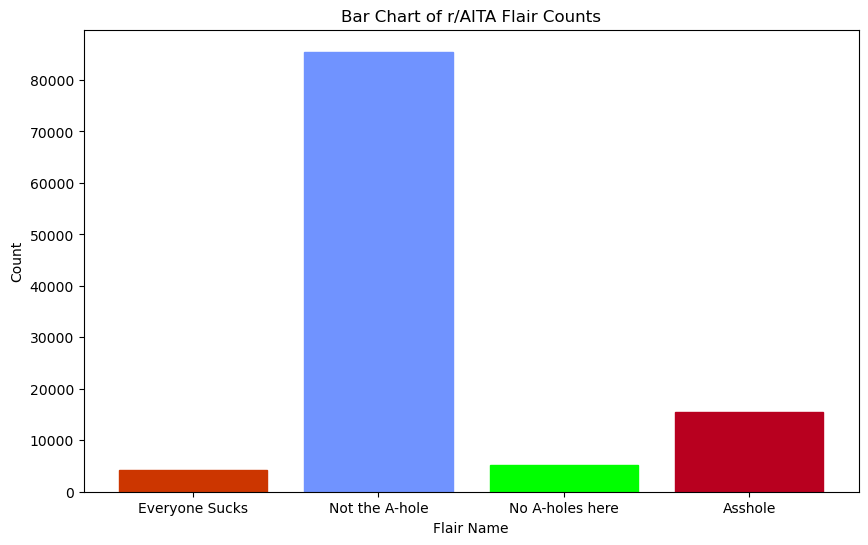

In [32]:
colors = ['#cc3600', '#7093ff', 'lime', '#b8001f']

plt.figure(figsize=(10, 6))
bars = plt.bar(df_flairs_viz["link_flair_text"], df_flairs_viz["count"])
for i in range(len(bars)):
    bars[i].set_color(colors[i])
plt.xlabel("Flair Name")
plt.ylabel("Count")
plt.title("Bar Chart of r/AITA Flair Counts")
plt.savefig("../img/eda-plots/AITA_flairs_barchart.png")
plt.show()

To more accurately assess the proportion of each flair's presence, a treemap is plotted below:

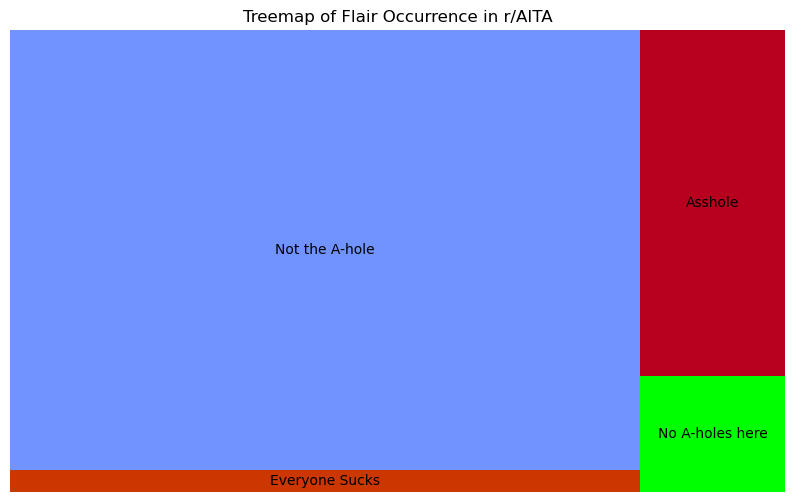

In [33]:
plt.figure(figsize = (10,6))
squarify.plot(sizes = df_flairs_viz['count'], color = colors, label = df_flairs_viz['link_flair_text'])
plt.axis('off')
plt.title("Treemap of Flair Occurrence in r/AITA")
plt.savefig("../img/eda-plots/AITA_flairs_treemap.png")

In [34]:
df_flairs_viz.to_csv("../data/eda-data/AITA_flairs_cleaned.csv")

# EDA for Score by Text Subreddit

In this section we perform exploratory analysis on the score (i.e., upvotes minus downvotes) of subreddits based on their text content. First, we remove any posts with deleted or empty text bodies.